v1.0

The objective of this notebook is to apply Principal Component Analysis (PCA) for visualizing high-dimensional feature datasets in text classification.

In [1]:
import time
t_start = time.time()

# 2.0 Setup Environment

## Install Modules

In [2]:
#!pip install watermark
#!pip install yellowbrick
#!pip install mglearn
#!pip install joblib==1.1.1
#!pip install pandas==1.4.1

## Import Modules

In [1]:
# Base libraries
import os
import re
import platform

# Scientific libraries
import numpy as np
import pandas as pd

# Specific libraries
#from ftlangdetect import detect

# Machine learning libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
import mglearn
import seaborn as sns

sns.set(rc={'figure.figsize': (15, 10)})
sns.set(font_scale=0.8)

# Helper libraries
from tqdm import tqdm
tqdm.pandas()
from watermark import watermark
import gc  # garbage collection to optimize memory usage, use gc.collect()
import warnings

warnings.filterwarnings('ignore')

# Pandas options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

# Load magic commands
%load_ext watermark

## Define Parameters

In [2]:
# sklearn
seed = 42

## Helper Functions

In [2]:
def feature_check(df, col):
    """Function to review features."""

    print("Feature name:", col)
    print('Data type:', df.dtypes[col])
    print('Missing values:', df[col].isna().sum())
    print('Count unique values:', df[col].nunique())
    print('Count -1 values (= missing):', len(df[df[col] == -1]))
    print()
    #print('Unique values:', sorted(list(df[col].unique())))
    print(df[col].describe())
    print()
    #print(df[col].value_counts().hist(figsize=(5,2)))
    if df[col].nunique() < 10000:
        try:
            sns.set(rc={'figure.figsize': (15, 5)})
            sns.histplot(x=col, data=df, hue='label');
            #df_temp = df[df[col] != -1]
            #sns.histplot(x=col, data=df_temp, hue='label');
        except:
            print("no distribution plot possible:")
    else:
        print("Too many unique values for a hist plot.")
    print()

# Load Data

## Import the files containing all the features generated during the feature creation and transformation stage

In [3]:
import os
import pandas as pd

try:
    from google.colab import drive
    drive.mount('/content/drive')
    PATH_ROOT = "/content/drive/MyDrive/MADS/SIADS696/Environment/"
except:
    print("Using shortcut location to load data.")
    PATH_ROOT = "/content/drive/MyDrive/SIADS696/Environment/"

# Define the paths to different directories and files in the project
PATHS = {
    "data": os.path.join(PATH_ROOT, "data"),
    "data_raw": os.path.join(PATH_ROOT, "data", "raw"),
    "data_int": os.path.join(PATH_ROOT, "data", "interim"),
    "data_pro": os.path.join(PATH_ROOT, "data", "processed"),
    "models": os.path.join(PATH_ROOT, "models"),
    "reports": os.path.join(PATH_ROOT, "reports"),
    "figures": os.path.join(PATH_ROOT, "reports", "figures"),
}

# Define the datasets with file paths as keys and variable names as values
DATASETS = {
    os.path.join(PATHS["data_int"], "train_features_clean_stats.parquet.gzip"): "df_wiki_train_stats",
    os.path.join(PATHS["data_int"], "test_features_clean_stats.parquet.gzip"): "df_wiki_test_stats",
    os.path.join(PATHS["data_int"], "train_features_rs.parquet.gzip"): "df_wiki_train_rs",
    os.path.join(PATHS["data_int"], "test_features_rs.parquet.gzip"): "df_wiki_test_rs",
    os.path.join(PATHS["data_int"], "train_features_nltk.parquet.gzip"): "df_wiki_train_nltk",
    os.path.join(PATHS["data_int"], "test_features_nltk.parquet.gzip"): "df_wiki_test_nltk",
    os.path.join(PATHS["data_int"], "train_features_aoa.parquet.gzip"): "df_wiki_train_aoa",
    os.path.join(PATHS["data_int"], "test_features_aoa.parquet.gzip"): "df_wiki_test_aoa",
    os.path.join(PATHS["data_int"], "train_features_crb.parquet.gzip"): "df_wiki_train_crb",
    os.path.join(PATHS["data_int"], "test_features_crb.parquet.gzip"): "df_wiki_test_crb",
    os.path.join(PATHS["data_int"], "train_features_w2v.parquet.gzip"): "df_wiki_train_w2v",
    os.path.join(PATHS["data_int"], "test_features_w2v.parquet.gzip"): "df_wiki_test_w2v",
}

# Load each dataset and store it in a variable with the same name as its value in the DATASETS dictionary
for filepath, variable_name in DATASETS.items():
    if filepath.endswith(".csv"):
        locals()[f"{variable_name}"] = pd.read_csv(filepath)
    elif filepath.endswith(".parquet.gzip"):
        locals()[f"{variable_name}"] = pd.read_parquet(filepath)
    else:
        raise ValueError(f"Unsupported file format for dataset {filepath}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Combine the training dataframes into a single dataframe


In [4]:
# Concatenate all training dataframes
df_train = pd.concat([df_wiki_train_stats, df_wiki_train_rs, df_wiki_train_nltk, df_wiki_train_aoa, df_wiki_train_crb, df_wiki_train_w2v], axis=1)

# Remove original_text and cleaned_text columns from the training dataframe
columns_list = sorted(list(set(df_train.columns) - {"original_text", "cleaned_text"}))

# Update training dataframe with the selected columns
df_train = df_train[columns_list]

# Print the number of features in the training dataframe
print("Features: ", len(columns_list))

Features:  153


## Combine the testing dataframes into a single dataframe

In [5]:
# Combine all the testing dataframes into one
df_test = pd.concat([
    df_wiki_test_stats, 
    df_wiki_test_rs, 
    df_wiki_test_nltk, 
    df_wiki_test_aoa, 
    df_wiki_test_crb, 
    df_wiki_test_w2v], axis=1)

# Remove original_text and cleaned_text columns from the testing dataframe
columns_list = sorted(list(set(df_test.columns) - {"original_text", "cleaned_text", "id"}))

# Update testing dataframe with the selected columns
df_test = df_test[columns_list]

# Print the number of features in the testing dataframe
print("Features: ", len(columns_list))

Features:  153


# Exploratory Data Analysis

## Basic statistical summary of numerical features for the training and testing datasets

### Training dataset

In [9]:
df_train.describe(exclude='object').round(2).T

,count,mean,std,min,25%,50%,75%,max
aoa_aoa_bird_lem_max,416768.0,6.98,2.52,-1.00,5.53,6.97,8.69,13.14
aoa_aoa_bird_lem_mean,416768.0,4.73,1.42,-1.00,4.61,4.93,5.28,12.98
aoa_aoa_bird_lem_min,416768.0,3.39,1.17,-1.00,3.16,3.63,3.92,12.98
aoa_aoa_bird_lem_sum,416768.0,43.14,27.53,-1.00,23.39,39.37,59.09,237.78
aoa_aoa_bristol_lem_max,416768.0,7.40,3.58,-1.00,6.30,8.41,9.75,13.64
aoa_aoa_bristol_lem_mean,416768.0,6.20,2.98,-1.00,5.67,6.83,7.95,13.64
aoa_aoa_bristol_lem_min,416768.0,5.11,2.75,-1.00,4.47,5.26,6.45,13.64
aoa_aoa_bristol_lem_sum,416768.0,20.45,16.64,-1.00,8.60,17.68,29.12,159.24
aoa_aoa_cort_lem_max,416768.0,6.04,2.45,-1.00,4.93,6.13,7.49,13.65
aoa_aoa_cort_lem_mean,416768.0,4.03,1.33,-1.00,3.83,4.20,4.57,13.57


### Testing dataset

In [10]:
df_test.describe(exclude='object').round(2).T

,count,mean,std,min,25%,50%,75%,max
aoa_aoa_bird_lem_max,119092.0,6.99,2.51,-1.00,5.53,6.97,8.69,13.14
aoa_aoa_bird_lem_mean,119092.0,4.74,1.41,-1.00,4.61,4.93,5.28,12.98
aoa_aoa_bird_lem_min,119092.0,3.39,1.17,-1.00,3.16,3.63,3.92,12.98
aoa_aoa_bird_lem_sum,119092.0,43.32,27.58,-1.00,23.56,39.60,59.46,206.64
aoa_aoa_bristol_lem_max,119092.0,7.42,3.57,-1.00,6.33,8.43,9.75,13.64
aoa_aoa_bristol_lem_mean,119092.0,6.21,2.97,-1.00,5.67,6.83,7.94,13.64
aoa_aoa_bristol_lem_min,119092.0,5.11,2.74,-1.00,4.47,5.26,6.45,13.64
aoa_aoa_bristol_lem_sum,119092.0,20.50,16.56,-1.00,8.60,17.82,29.16,141.23
aoa_aoa_cort_lem_max,119092.0,6.06,2.45,-1.00,4.99,6.13,7.50,13.65
aoa_aoa_cort_lem_mean,119092.0,4.03,1.32,-1.00,3.84,4.21,4.58,13.20


## Generate histograms of each feature in the simple/complex text classification classes

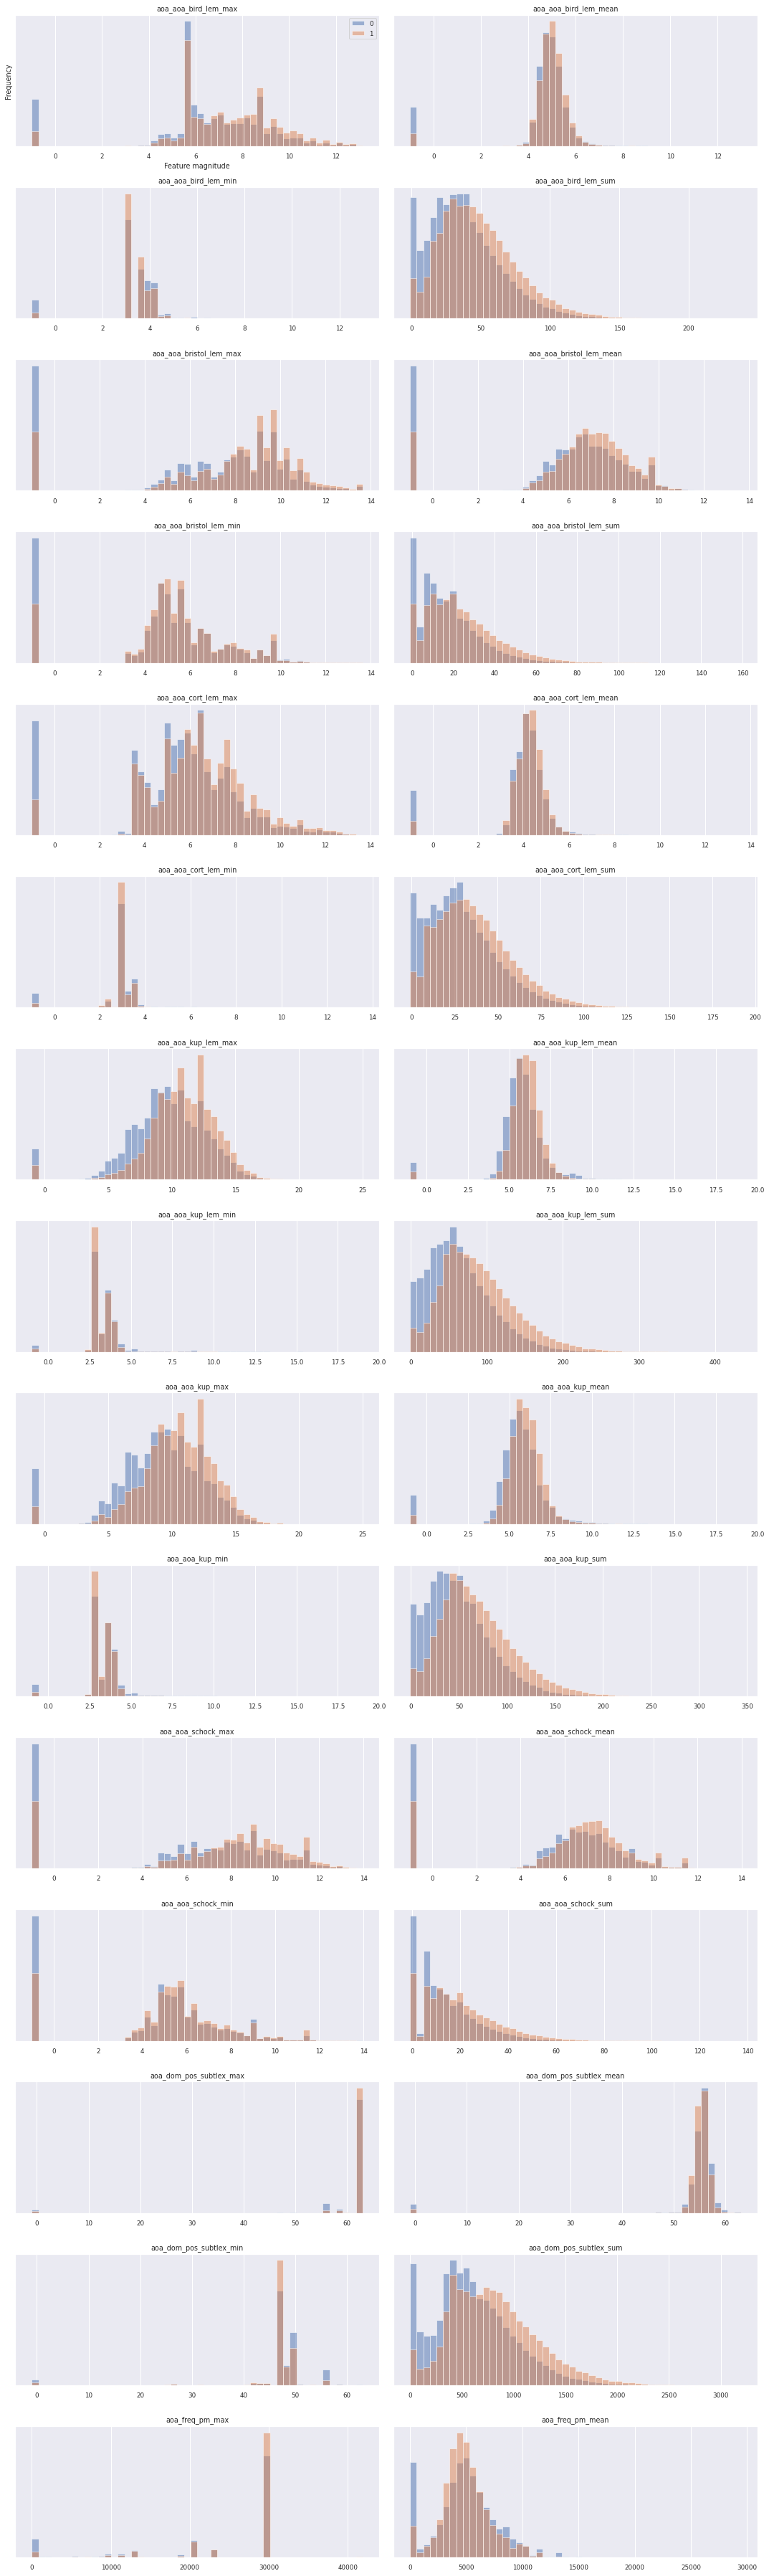

In [11]:
# Calculate the number of rows needed for the subplots 
#plots_count = int(len(df_train.columns) / 2 + 1)
plots_count = int(15)

# Create subplots with the determined number of rows and 2 columns
# figsize parameter sets the size of the plot
fig, axes = plt.subplots(plots_count, 2, figsize=(15, 50))

# Filter rows with label 0 and store it in label_0
label_0 = df_train[df_train.label == 0]

# Filter rows with label 1 and store it in label_1
label_1 = df_train[df_train.label == 1]

# Flatten the array of subplots into a 1D array
ax = axes.ravel()

# Iterate over each column in training dataframe
#for i, col in enumerate(df_train.columns):
for i, col in enumerate(df_train.columns):# Limit export to 30 features to speed up execution
  if i < 30:
    _, bins = np.histogram(df_train[col], bins=50)
    _ = ax[i].hist(label_0[col], bins=bins, alpha=.5)
    _ = ax[i].hist(label_1[col], bins=bins, alpha=.5)
    ax[i].set_title(col)
    ax[i].set_yticks(())
  else:
    break

ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["0", "1"], loc="best")
fig.tight_layout();

## Visualize high-dimensional datasets of features using Principal Component Analysis (PCA)

### Scale data to have unit variance using MinMaxScaler before applying PCA

In [12]:
# Select numeric columns as training data
X_train = df_train.select_dtypes(include=[np.number]).drop('label', axis=1)

# Initialize the RobustScaler
#scaler = RobustScaler()

# initialize MinMaxScaler
scaler = MinMaxScaler((0,1))

# Fit and transform the data using the scaler
X_scaled = scaler.fit_transform(X_train)

# The transformed data now has zero median and unit interquartile range
#print(X_scaled)

### Display the first two principal components



In [13]:
from sklearn.decomposition import PCA

# Perform PCA on the scaled data
pca = PCA(n_components=2)
_ = pca.fit(X_scaled)

# Transform data onto the first two principal components
X_pca = pca.transform(X_scaled)
print("Original shape:", X_scaled.shape)
print("Reduced shape:", X_pca.shape)

Original shape: (416768, 151)
Reduced shape: (416768, 2)


<Figure size 1440x720 with 0 Axes>

Text(0.5, 0, 'First Principal Component')

Text(0, 0.5, 'Second Principal Component')

Text(0.5, 1.0, 'PCA Components Colored by Class')

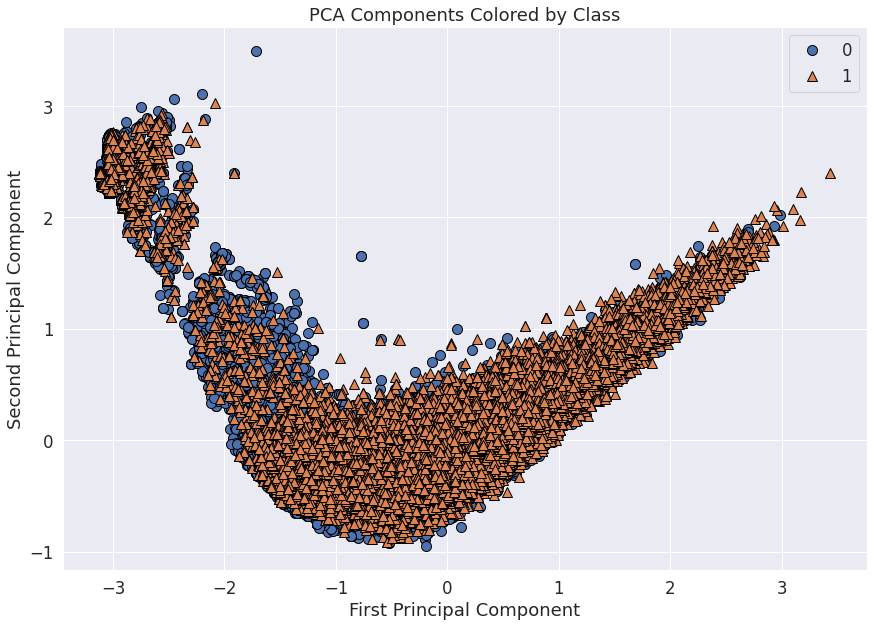

In [14]:
# Plot the first vs. second principal component, colored by class
sns.set(font_scale=1.5)
plt.figure(figsize=(20, 10))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], df_train.label)
plt.legend([0, 1], loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA Components Colored by Class") # Add chart title

# Save the plot as a PNG image in the current directory
plt.savefig('pca_components.png', dpi=300, bbox_inches='tight')

### Vizualize the PCA coefficients using a heat map

Text(0.5, 1.0, 'Heatmap of PCA Components')

([<matplotlib.axis.YTick at 0x7f57686bea60>,
 [Text(0, 0, 'First PC'), Text(0, 1, 'Second PC')])

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Principal Components')

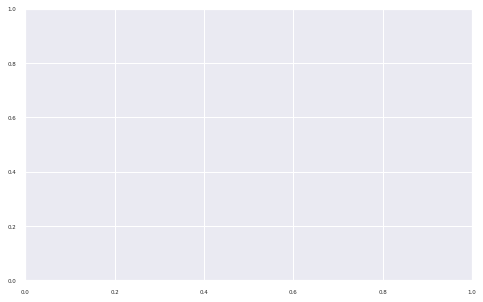

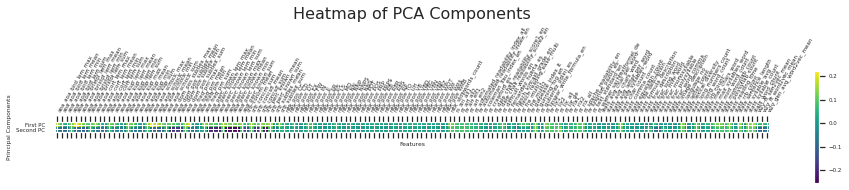

In [15]:
# Print the shape of the Principal Component Analysis (PCA) components
#print(f"PCA component shape: {pca.components_.shape}")

# Print the Principal Component Analysis (PCA) components
#print(f"PCA components:\n{pca.components_}")

# Initialize the figure and specify the figure size
sns.set(font_scale=0.5)
fig = plt.subplots(figsize=(8, 5))

# Plot a matrix using matplotlib's matshow function
plt.matshow(pca.components_, cmap='viridis')
plt.title("Heatmap of PCA Components", fontdict={'fontsize': 16}) # Add chart title and increase font size

# Set the y-axis tick labels to "First Principal Component" and "Second Principal Component"
plt.yticks([0, 1], ["First PC", "Second PC"])

# Show the color bar
plt.colorbar()

# Set the x-axis tick labels to the names of the features, with a 60 degree rotation and left alignment
xticks = plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=60, ha='left')

# Set the x-axis label to "Features"
plt.xlabel("Features")

# Set the y-axis label to "Principal Components"
plt.ylabel("Principal Components")

# Save the plot as a PNG image in the current directory
plt.savefig('pca_heatmap_all_features.png', dpi=300, bbox_inches='tight')

In [16]:
# Initialize the figure and specify the figure size
#sns.set(font_scale=0.3)
#fig, ax = plt.subplots(figsize=(25, 5))

# Plot the PCA components using seaborn's heatmap function
#sns.heatmap(pca.components_, cmap='viridis', annot=True, ax=ax)

# Set the y-axis tick labels to "First Principal Component" and "Second Principal Component"
#ax.set_yticklabels(["First PC", "Second PC"])

# Set the x-axis tick labels to the names of the features, with a 60 degree rotation
#_ = plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=60, ha='left')

# Set the x-axis label to "Features"
#ax.set_xlabel("Features")

# Set the y-axis label to "Principal Components"
#ax.set_ylabel("Principal Components")

# Save the plot as a PNG image in the current directory
#plt.savefig('plot.png', dpi=300, bbox_inches='tight')

<BarContainer object of 10 artists>

Text(0.5, 0, 'Principal Component')

Text(0, 0.5, 'Explained Variance')

Text(0.5, 1.0, 'PCA - Explained Variance by Principal Component')

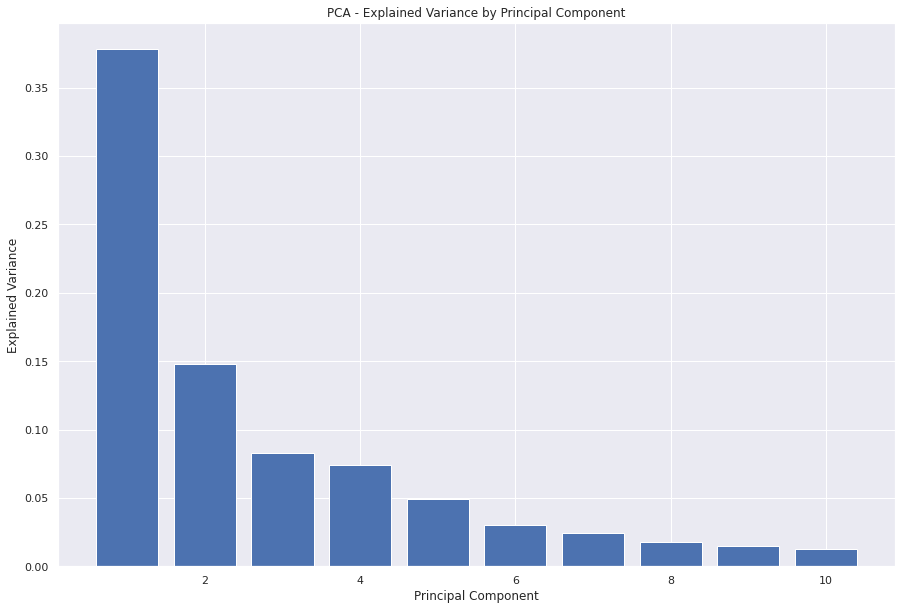

<Figure size 1080x720 with 0 Axes>

In [17]:
# Perform PCA on the scaled data
pca = PCA(n_components=10)  # Change from none to 4 - for testing
pca_components = pca.fit(X_scaled)

# Set font scale for the plot
sns.set(font_scale=1.0)

# Plot explained variance by each principal component
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('PCA - Explained Variance by Principal Component')
plt.show();

# Save the plot to a file
plt.savefig('pca_components.png', dpi=300, bbox_inches='tight')

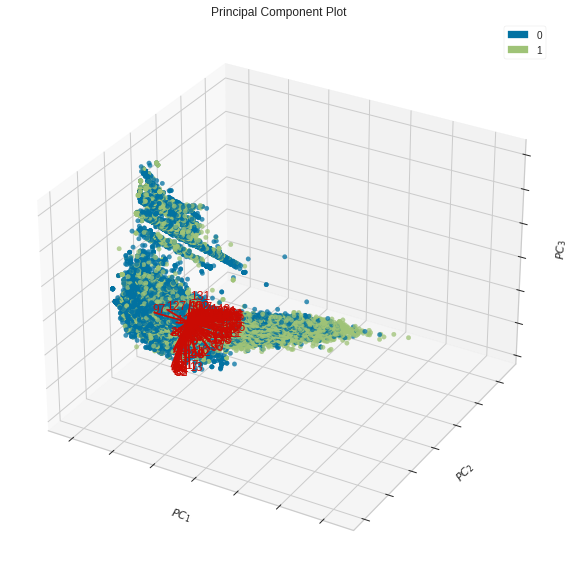

In [18]:
from yellowbrick.features import PCA

# Plot the first two principal components with different color for each class
visualizer = PCA(scale=True, projection=3, proj_features=True, size=(1500, 720))

# Fit and transform the scaled data and its labels
_ = visualizer.fit_transform(X_scaled, df_train.label)

# Show the visualization and export to a file
visualizer.show(outpath='pca_viz_components.png');

## Analysis of 'stats_char_count', 'w2v_gen_avg_word2vec_mean', 'aoa_aoa_kup_lem_mean', 'w2v_ft_sen2vec_mean', 'rs_rix1', and 'rs_ari_all2'

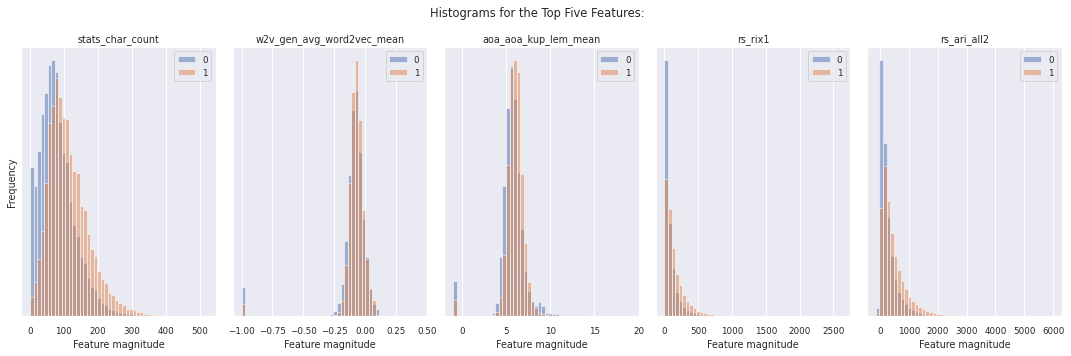

In [10]:
# Define the columns to focus on
focus_columns = ["stats_char_count", "w2v_gen_avg_word2vec_mean", "aoa_aoa_kup_lem_mean", "rs_rix1", "rs_ari_all2"]

# Define the number of subplots to display
plots_count = 5

# Calculate the number of rows and columns needed for the subplots 
plots_per_row = 5
rows = int((plots_count - 1) / plots_per_row) + 1
cols = min(plots_count, plots_per_row)

# Create subplots with the determined number of rows and columns
# figsize parameter sets the size of the plot
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))

# Filter rows with label 0 and store it in label_0
label_0 = df_train[df_train.label == 0]

# Filter rows with label 1 and store it in label_1
label_1 = df_train[df_train.label == 1]

# Flatten the array of subplots into a 1D array
ax = axes.ravel()

# Iterate over each column in the focus columns and each subplot
for i, col in enumerate(focus_columns[:plots_count]):
    _, bins = np.histogram(df_train[col], bins=50)
    j = i % cols
    k = i // cols
    _ = ax[i].hist(label_0[col], bins=bins, alpha=.5)
    _ = ax[i].hist(label_1[col], bins=bins, alpha=.5)
    ax[i].set_title(col)
    ax[i].set_yticks(())
    if k == rows - 1:
        ax[i].set_xlabel("Feature magnitude")
    if j == 0:
        ax[i].set_ylabel("Frequency")
    ax[i].legend(["0", "1"], loc="best")

# Add a title to the entire chart
fig.suptitle("Histograms for the Top Five Features:")

fig.tight_layout();

Original shape: (416768, 6)
Reduced shape: (416768, 2)


<Figure size 1440x720 with 0 Axes>

Text(0.5, 0, 'First Principal Component')

Text(0, 0.5, 'Second Principal Component')

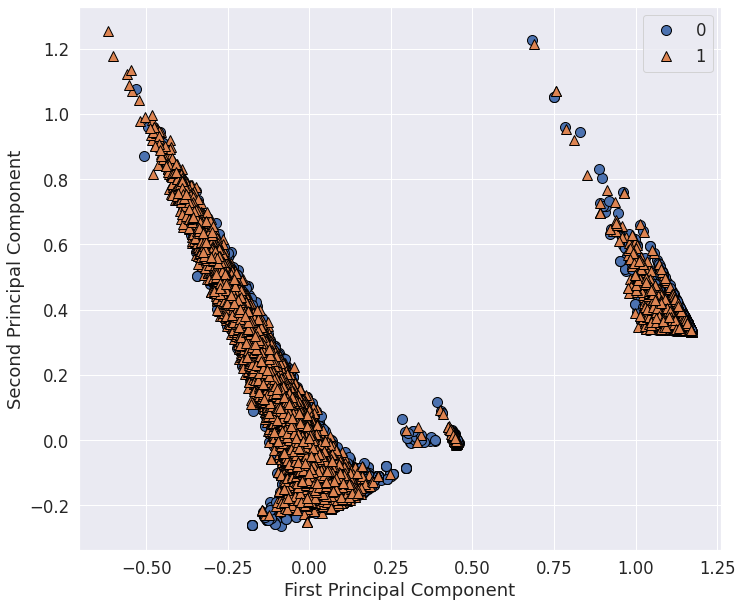

In [9]:
from sklearn.decomposition import PCA

# Select only the specified features
#selected_features = ["stats_char_count", "w2v_gen_avg_word2vec_mean", "aoa_aoa_kup_lem_mean", "w2v_ft_sen2vec_mean", "rs_rix1", "rs_ari_all2"]
selected_features = ["stats_char_count", "w2v_gen_avg_word2vec_mean", "aoa_aoa_kup_lem_mean", "rs_rix1", "rs_ari_all2"]
X_train = df_train[selected_features]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data using the scaler
X_scaled = scaler.fit_transform(X_train)

# Perform PCA on the scaled data
pca = PCA(n_components=2)
_ = pca.fit(X_scaled)

# Transform data onto the first two principal components
X_pca = pca.transform(X_scaled)
print("Original shape:", X_scaled.shape)
print("Reduced shape:", X_pca.shape)

# Plot the first vs. second principal component, colored by class
sns.set(font_scale=1.5)
plt.figure(figsize=(20, 10))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], df_train.label)
plt.legend([0, 1], loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

# Save the plot as a PNG image in the current directory
plt.savefig('pca_components.png', dpi=300, bbox_inches='tight')

PCA components:
[[-0.34804994 -0.51364024 -0.1682581  -0.72309232 -0.15634402 -0.19854015]
 [ 0.68310393 -0.25793943  0.00512575 -0.3515191   0.36509724  0.45820119]]


([<matplotlib.axis.YTick at 0x7f443fd4e2b0>,
 [Text(0, 0, 'First PC'), Text(0, 1, 'Second PC')])

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Principal Components')

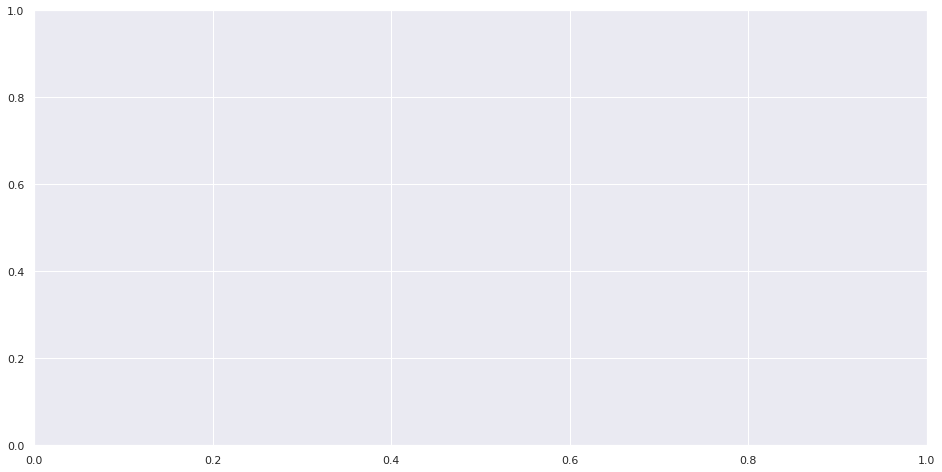

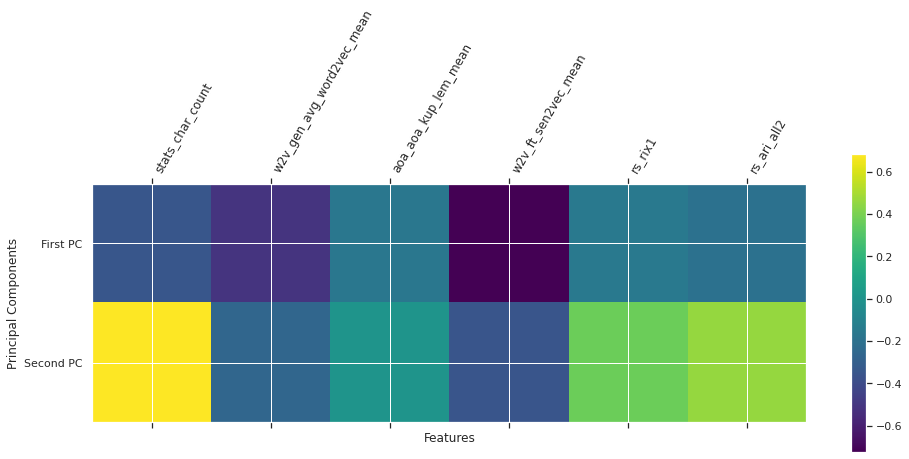

In [10]:
# Print the Principal Component Analysis (PCA) components
print(f"PCA components:\n{pca.components_}")

# Initialize the figure and specify the figure size
sns.set(font_scale=1.0)
fig = plt.subplots(figsize=(16, 8))

# Plot a matrix using matplotlib's matshow function
plt.matshow(pca.components_, cmap='viridis')

# Set the y-axis tick labels to "First Principal Component" and "Second Principal Component"
plt.yticks([0, 1], ["First PC", "Second PC"], ha='right')

# Show the color bar
plt.colorbar()

# Set the x-axis tick labels to the names of the features, with a 60 degree rotation and left alignment
xticks = plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=60, ha='left', fontsize=12)

# Set the x-axis label to "Features"
plt.xlabel("Features", fontsize=12)

# Set the y-axis label to "Principal Components"
plt.ylabel("Principal Components", fontsize=12)

# Set the title of the plot
#plt.title("PCA Components Heatmap", fontsize=12)

# Save the plot as a PNG image in the current directory
plt.savefig('pca_heatmap.png', dpi=300, bbox_inches='tight')

<BarContainer object of 4 artists>

Text(0.5, 0, 'Principal Component')

Text(0, 0.5, 'Explained Variance')

Text(0.5, 1.0, 'PCA - Explained Variance by Principal Component')

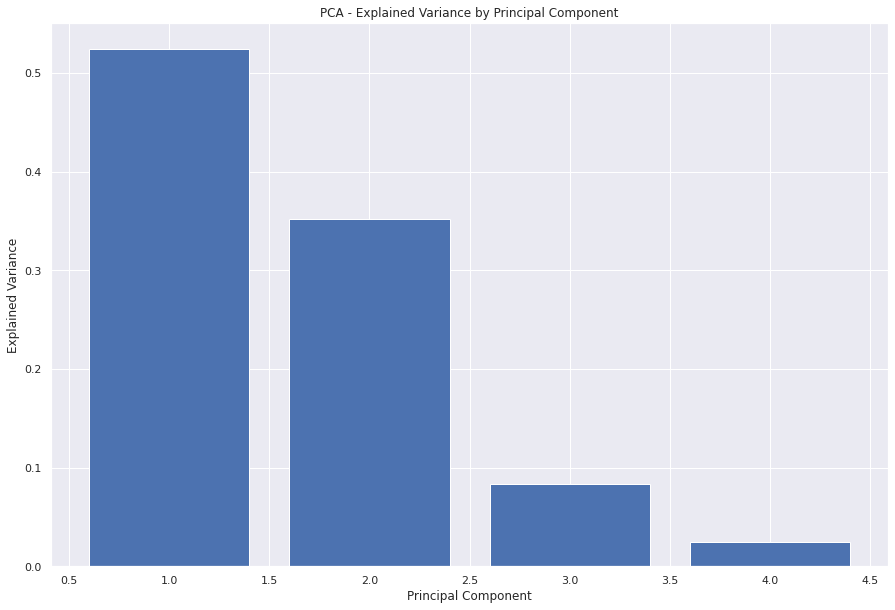

<Figure size 1080x720 with 0 Axes>

In [11]:
# Perform PCA on the scaled data
pca = PCA(n_components=4)  # Change from none to 4 - for testing
pca_components = pca.fit(X_scaled)

# Set font scale for the plot
sns.set(font_scale=1.0)

# Plot explained variance by each principal component
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('PCA - Explained Variance by Principal Component')
plt.show();

# Save the plot to a file
plt.savefig('pca_components.png', dpi=300, bbox_inches='tight')

<Axes3DSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

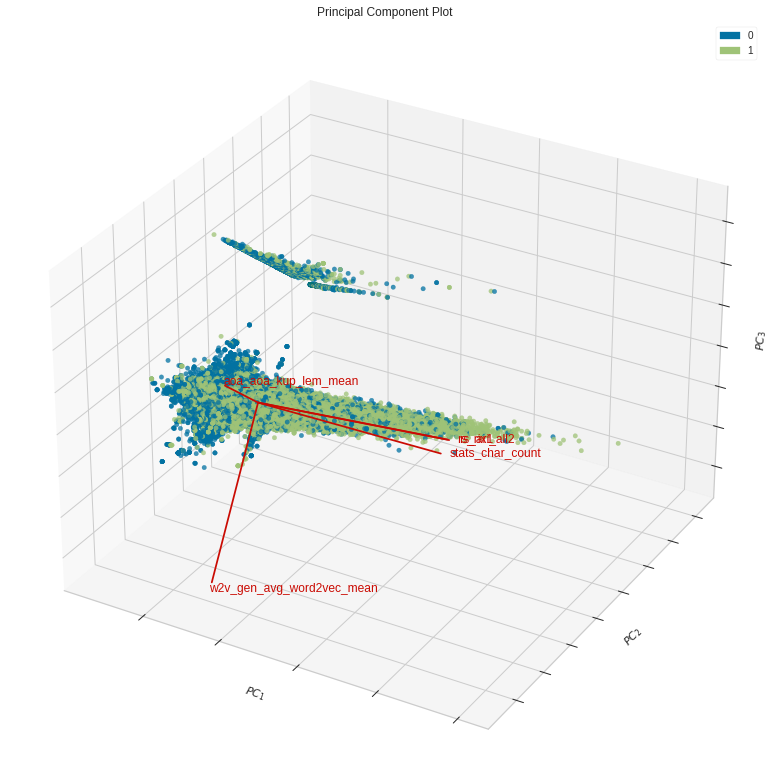

In [12]:
from yellowbrick.features import PCA

# Select only the specified features
#selected_features = ["stats_char_count", "w2v_gen_avg_word2vec_mean", "aoa_aoa_kup_lem_mean", "w2v_ft_sen2vec_mean", "rs_rix1", "rs_ari_all2"]
selected_features = ["stats_char_count", "w2v_gen_avg_word2vec_mean", "aoa_aoa_kup_lem_mean", "rs_rix1", "rs_ari_all2"]
X_train = df_train[selected_features]

# Specify the feature names
feature_names = X_train.columns

# Define the color map for labels
label_colors = {0: 'orange', 1: 'blue'}

# Initialize the PCA visualization class with scaling and projection of features
visualizer = PCA(scale=True, proj_features=True, projection=3, feature_names=feature_names, size=(1200, 1000), color=map(lambda x: label_colors[x], df_train.label))

# Fit and transform the scaled data and its labels
_ = visualizer.fit_transform(X_train, df_train.label)

# Show the visualization and export to a file
visualizer.show(outpath='pca_viz_components_top6.png')

# Watermark

In [ ]:
% watermark

In [ ]:
% watermark --iversions

In [ ]:
t_end = time.time()
total_runtime = t_end - t_start
total_runtime_min = round((total_runtime / 60), 2)
print(str(total_runtime_min) + " minutes")